In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
folder = "/home/ovs2/lining/manual/AFQ10/"

In [3]:
def read_out_tr(dir, file):
    col = ["events", "time", "from_node", "to_node", "pkt_type", "pkt_size", "flags", "fid", "src_addr", "dst_addr", "seq_num", "pkt_id"]
    df = pd.read_csv(dir+file, sep = ' ', header = None)
    df.columns = col
    return df

In [4]:
def get_received_packets(df, node):
    # Getting the reveived tcp pkts at the receiving node
    # node: the number of the receiving node
    df_out = df.loc[df["events"].isin(["r"])]
    df_out = df_out.loc[df_out["pkt_type"].isin(["tcp"])]
    df_out = df_out.loc[df_out["to_node"].isin([node])]
    return df_out

In [5]:
# Short-term throughput by Lining
def plot_short_th(df_out_tr, window_size, node):
    # Getting the short-term throughput in a cirtain window size
    # node: the number of the receiving node
    # window_size: the jumping window size observing the short-term window size (in us)
    r_event_in_dst = get_received_packets(df_out_tr, node)
    r_event_in_dst['ts'] = r_event_in_dst['time'].apply(lambda x: pd.Timedelta(x,unit='s'))
    
    grouped=r_event_in_dst.groupby('fid')
    
    pkt_size_series = pd.Series(r_event_in_dst['pkt_size'], index=r_event_in_dst['ts'])
    
    # H       hourly frequency
    # T, min  minutely frequency
    # S       secondly frequency
    # L, ms   milliseonds
    # U, us   microseconds
    # N       nanoseconds

    shortTh = grouped[['ts', 'pkt_size']].resample(str(window_size) + 'U', on='ts').sum()
    # Gbps
    shortTh['throughtput'] = shortTh['pkt_size']*8 / (window_size * 1e-6) / 1000 / 1000 / 1000
    res = shortTh[['throughtput']]
    #res.index = res.index.set_levels(res.index.get_level_values('ts') / timedelta(seconds=1), level=1)
    ax=None
    fids=[]
    for fid, _ in grouped:
        res_fid = res.loc[fid]
        res_fid['time'] = res_fid.index / timedelta(seconds=1)
        ax=res_fid.plot(x='time', y='throughtput', ax=ax, figsize=(18,5), kind='line', legend=True, title='shortTh', grid=True)
        fids.append(fid)
    plt.xlabel('time')
    plt.ylabel('throughput (Gbps)')
    plt.legend(fids)
    plt.show()

In [6]:
dir = "/home/ovs2/lining/Gearbox/manual/AFQ10/"
file = "out.tr"

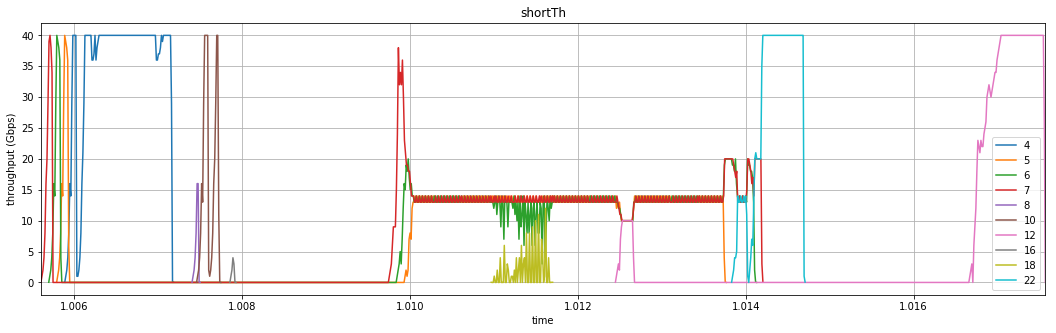

In [7]:
df_out_tr = read_out_tr(dir, file)
plot_short_th(df_out_tr, 12, 35)